In [1]:
from sklearn.datasets import make_blobs, make_moons
import torch
from torch import nn
import pandas as pd
import seaborn as sns
import seaborn
from torch.optim import SGD
import torch.nn.functional as F
import numpy as np

RANDOM_STATE = 45

np.random.seed(RANDOM_STATE)

import matplotlib.pyplot as plt
%matplotlib inline

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(7)

# DONT WORRY ABOUT THIS CODE VISUALIZATION ONLY

def plot_decision_boundry(net, X, line='g--'):
    W = net.fc.weight[0].detach().cpu().numpy()
    b = net.fc.bias.detach().cpu().numpy()
    f = lambda x: (-W[0]/W[1]) * x +  (-b/W[1])
    dziedz = np.arange(-1, 1, 0.01)
    plt.plot(dziedz, f(dziedz), line) 
    plt.xlim((-1, 1))
    plt.ylim((-1, 1))
    
    
def plot_decision_space(net, X, Y):
    xx, yy = np.mgrid[-1:1:.01, -1:1:.01]
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = torch.sigmoid(net(torch.from_numpy(grid).float().cuda())).view(-1, 1).view(xx.shape)
    f, ax = plt.subplots(figsize=(8, 6))


    contour = ax.contourf(xx, yy, probs.detach().cpu().numpy(), 25, cmap="RdBu",
                          vmin=0, vmax=1)
    ax_c = f.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, .25, .5, .75, 1])

    ax.scatter(X[:,0], X[:, 1], c=Y, s=50,
               cmap="RdBu", vmin=-.2, vmax=1.2,
               edgecolor="white", linewidth=1)

    ax.set(aspect="equal",
           xlim=(-1, 1), ylim=(-1, 1),
           xlabel="$X_1$", ylabel="$X_2$")
    
    
def visualize_data(X, Y):
    f, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(X[:,0], X[:, 1], c=Y, s=50,
               cmap="RdBu", vmin=-.2, vmax=1.2,
               edgecolor="white", linewidth=1)

    ax.set(aspect="equal",
           xlabel="$X_1$", ylabel="$X_2$")    
    
    

# Prepare and Visualize data

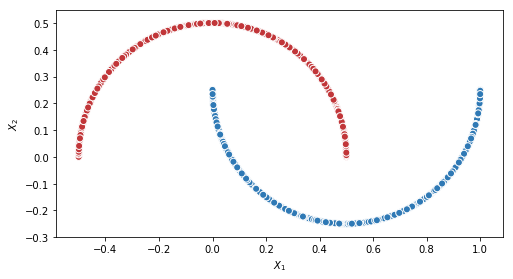

In [2]:
N_FEATURES = 2

X, Y = make_blobs(centers=2, random_state=RANDOM_STATE, n_features=N_FEATURES)
X, Y = make_moons(n_samples=1000)
X = X/np.abs(X).max()
visualize_data(X,Y)


In [3]:
data = pd.DataFrame(X, columns=['x1','x2'])
data['target'] = Y
data

,x1,x2,target
0,0.426294,-0.244538,1
1,0.020456,0.499581,0
2,-0.274998,0.417584,0
3,0.994767,0.177851,1
4,0.937910,0.008682,1
5,0.227636,-0.169307,1
6,-0.023600,0.499443,0
7,0.167624,-0.123532,1
8,0.489248,0.103135,0
9,0.942390,0.016995,1


In [4]:
pd.DataFrame(Y).head()

,0
0,1
1,0
2,0
3,1
4,1


# Define the perceptron


![alt text](https://cdn-images-1.medium.com/max/1600/1*-JtN9TWuoZMz7z9QKbT85A.png "Title")


In [5]:
torch.manual_seed(7)


In [6]:

input_tensor = torch.randn((1,2))

linear_layer = nn.Linear(2, 1, bias=False)

linear_layer(input_tensor)

print(linear_layer.weight)
print(input_tensor)
output = linear_layer(input_tensor)
print(output)

print(input_tensor.shape)
manual_output = input_tensor.mm(linear_layer.weight.transpose(0, 1))
print(manual_output)
assert output == manual_output

Parameter containing:
tensor([[-0.3779, -0.1060]], requires_grad=True)
tensor([[-0.1468,  0.7861]])
tensor([[-0.0278]], grad_fn=<MmBackward>)
torch.Size([1, 2])
tensor([[-0.0278]], grad_fn=<MmBackward>)


In [7]:

class Perceptron(nn.Module):
    def __init__(self, n_in):

        super(Perceptron, self).__init__()
        self.fc1 = nn.Linear(2, 10, bias=True)
        self.fc2 = nn.Linear(10, 10, bias=True)
        self.fc3 = nn.Linear(10, 1, bias=True)
    
    def forward(self, x):
        return self.fc3(F.relu(self.fc2(F.relu(self.fc1(x)))))

def custom_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.zeros_(m.weight)
#         m.weight.fill_(0)
        m.bias.data.fill_(0)
        
perceptron = Perceptron(2)

# Linear layers get their weights initialized by default, but you can reinitialize them if needed.
perceptron.apply(custom_weights)

# print("fc weight", perceptron.fc.weight)
# print("bias weight", perceptron.fc.bias)

Perceptron(
  (fc1): Linear(in_features=2, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
)

In [8]:
[p for p in dir(perceptron) if not p.startswith('_')]

['add_module',
 'apply',
 'buffers',
 'children',
 'cpu',
 'cuda',
 'double',
 'dump_patches',
 'eval',
 'extra_repr',
 'fc1',
 'fc2',
 'fc3',
 'float',
 'forward',
 'half',
 'load_state_dict',
 'modules',
 'named_buffers',
 'named_children',
 'named_modules',
 'named_parameters',
 'parameters',
 'register_backward_hook',
 'register_buffer',
 'register_forward_hook',
 'register_forward_pre_hook',
 'register_parameter',
 'share_memory',
 'state_dict',
 'to',
 'train',
 'training',
 'type',
 'zero_grad']

# Train Loop Using CrossEntropy



While using crossentropy loss our model needs to return (BS, n_classes) output tensor, the target has to be a coresponding dense label vector of shape (BS, 1)

In [9]:
# list(net.pa)
net = Perceptron(2)
list(net.parameters())
optimizer = SGD(net.parameters(), lr=0.01)
optimizer.__dict__

{'defaults': {'lr': 0.01,
  'momentum': 0,
  'dampening': 0,
  'weight_decay': 0,
  'nesterov': False},
 'state': defaultdict(dict, {}),
 'param_groups': [{'params': [Parameter containing:
    tensor([[ 0.2511,  0.5759],
            [-0.4680, -0.1862],
            [ 0.0595, -0.4033],
            [-0.6557,  0.3096],
            [-0.5802, -0.1775],
            [-0.3755,  0.5318],
            [ 0.1365,  0.3279],
            [-0.4788,  0.5959],
            [ 0.0630, -0.3922],
            [-0.0463, -0.5007]], requires_grad=True), Parameter containing:
    tensor([-0.0326,  0.3949, -0.3179,  0.5977,  0.2159, -0.1237,  0.2209, -0.1303,
            -0.1643, -0.4639], requires_grad=True), Parameter containing:
    tensor([[ 0.1843,  0.1898,  0.1083,  0.1870,  0.3159,  0.2978, -0.3052,  0.0721,
             -0.0271,  0.1074],
            [-0.0613,  0.0883, -0.2910,  0.1445,  0.3038, -0.0569, -0.2515, -0.2629,
             -0.0607, -0.0048],
            [ 0.0353,  0.0397,  0.2382, -0.0574,  0.090

training epoch 0


/home/i008/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


torch.Size([1000, 2])
torch.Size([1000])
model acc is:  0.894
training epoch 1
torch.Size([1000, 2])
torch.Size([1000])
model acc is:  0.91
training epoch 2
torch.Size([1000, 2])
torch.Size([1000])
model acc is:  1.0
training epoch 3
torch.Size([1000, 2])
torch.Size([1000])
model acc is:  1.0
training epoch 4
torch.Size([1000, 2])
torch.Size([1000])
model acc is:  1.0
training epoch 5
torch.Size([1000, 2])
torch.Size([1000])
model acc is:  1.0
training epoch 6
torch.Size([1000, 2])
torch.Size([1000])
model acc is:  1.0
training epoch 7
torch.Size([1000, 2])
torch.Size([1000])
model acc is:  1.0
training epoch 8
torch.Size([1000, 2])
torch.Size([1000])
model acc is:  1.0
training epoch 9
torch.Size([1000, 2])
torch.Size([1000])
model acc is:  1.0
input shape (BS, n_classes): torch.Size([4, 2])
target shape (BS, 1): torch.Size([4, 1])
output shape torch.Size([4, 1])


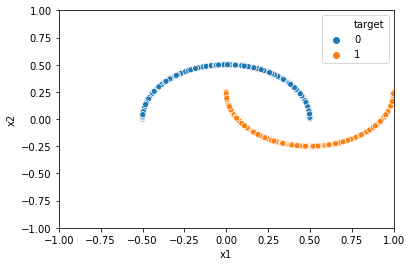

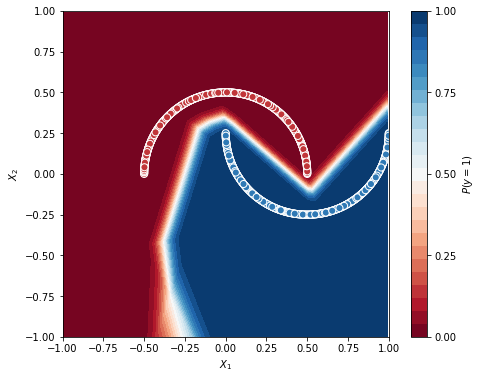

In [119]:
N_EPOCHS = 10

# init the model, loss and optimizer
net = Perceptron(2)
from torch.optim import Adam

optimizer = SGD(net.parameters(), lr=0.1)
criterion = nn.BCEWithLogitsLoss()
net = net.to(DEVICE)

loss_history = []
# neural_network.fit(X, y)
for epoch in range(N_EPOCHS):
    print("training epoch {}".format(epoch))
    
    for xsample,ysample in zip(X, Y):
        optimizer.zero_grad() 
        # zero the gradients
        
        # batch preparation

#         x = torch.Tensor(xsample).unsqueeze(0) # tensor([[0.8745, 0.5205]]) torch.Size([1, 2])
#         y = torch.Tensor([ysample]).unsqueeze(0) # tensor([[1.]]) torch.Size([1, 1])
#         x = x.to(DEVICE)
#         y = y.to(DEVICE)
        
        if True:
            ix = np.random.randint(0, size=(4,), high=len(X))
            x = torch.tensor((X[ix, :])).float()
            y = torch.tensor(torch.Tensor(Y[ix]).reshape(-1,1)).float()
            x = x.to(DEVICE)
            y = y.to(DEVICE)
        
        # forward pass
        out = net(x)

        # loss calculation
        loss = criterion(out, y)

        # calculating gradients
        loss.backward()

        # changing the weights by specified(in the optimizer init) learning rate
        optimizer.step()
        
        #append calculated loss to the history
        loss_history.append(loss.detach().cpu().numpy())
    calculate_acc(net, X, Y)
        
#     plot_decision_boundry(net, X)
# at the end plot final solution in red
# plot_decision_boundry(net, X, 'r-')
seaborn.scatterplot(x='x1',y='x2', hue='target', data=data)
plt.xlim((-1, 1))
plt.ylim((-1, 1))

plot_decision_space(net, X, Y)
        
print("input shape (BS, n_classes):", x.shape)
print("target shape (BS, 1):", y.shape)
print("output shape", out.shape)

# def score_model(net, X, Y)

In [109]:
def calculate_acc(net, X, Y):
    
    net.eval()
    

    Xtorch = torch.from_numpy(X).float().cuda()
    ytorch = torch.from_numpy(Y).float().cuda()

    with torch.no_grad():
        predictions = net(Xtorch)
    predictions = (predictions.sigmoid() > .5).squeeze(-1)
    predictions = np.array(predictions.cpu())
    
    real = np.array(ytorch.cpu())
    acc = sum(predictions==real)/len(predictions)
    print("model acc is: ", acc)
    
    net.train()

Text(0,0.5,'loss (CE)')

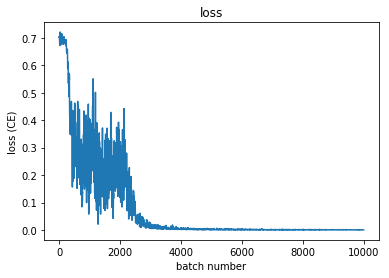

In [120]:
history = pd.DataFrame(loss_history, columns=['loss'])
history.loss[:].rolling(10).mean().plot()
plt.title("loss")
plt.xlabel("batch number")
plt.ylabel("loss (CE)")

# history[::10].plot()


## Exercises
1) Play with the training loop, enojoy the fact that you can inspect all the values dynamically. Consider using pdb.set_trace() for instance  
2) Can you edit the Perceptron class to create a Multi Layer Perceptron? (ie having more then 0 hidden layers)  
3) Initialize the the initial weights to 0. What do you think will happen? Can we still train the perceptron?  
4) What kind of gradient descnet are we using here? Stochastic? Batch? or Vanilla?  
5) What does detach do and why do we have to call it? (use google)  
6) Try adding a RELU activation after Linear unit - Will it train?
7) Try to implement a progress-bar (it might come in handy in our future exercises to)  
8) We can see the loss never going to 0, but the accuracy probably is reaching 100% - calculate ACC each epoch
9) Implement 

In [27]:
from IPython.display import HTML
HTML('<iframe src=https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=gauss&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=&seed=0.19214&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false width=1000 height=600></iframe>')

In [76]:
1+1

2

In [ ]:
# %load .solutions/2_notebook_solutions.py

# Implementing minibatch training
        
# if USE_MINI_BATCH:
#     ix = np.random.randint(0, size=(4,), high=len(X))
#     x = torch.tensor((X[ix, :])).float()
#     y = torch.tensor(torch.Tensor(Y[ix]).reshape(-1,1)).float()

In [115]:
%%timeit

# with torch.no_grad():
predictions = net(Xtorch)


131 µs ± 363 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
